<a href="https://colab.research.google.com/github/ceroytres/website_notebooks/blob/master/simple_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import random
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

seed = 123
# Set random seeds
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)


# Setup

The $p_{\text{data}}$ data distribution equals a Gaussian distribution $\mathcal{N}(3,1)$. We will assume the generator is using the following noise prior $z\sim\mathcal{N}(0,1)$ and the generator has the following form $G(z;b) = z + b$. The discriminator has following form $D(x;[w,c]) = \sigma(wx + c)$ where $\sigma$ is a sigmoid. Here we initialize $b=0$ and $c=0$ and $w$ is drawn from a $\mathcal{N}(0,1)$.

In [0]:
class Generator(nn.Module):

  def __init__(self, init_value=0):
    super(Generator, self).__init__()
    self.bias = nn.Parameter(torch.zeros(1)+init_value)


  def forward(self, x):
    z =  x + self.bias
    return z

class Discriminator(nn.Module):

  def __init__(self, init_value = 0 ):
    super(Discriminator, self).__init__()
    self.bias = nn.Parameter(torch.zeros(1)+init_value)
    self.w = nn.Parameter(torch.randn(1))

  def forward(self, x):
    logit = self.w * x + self.bias
    D = torch.sigmoid(logit)

    return D


# Create the generator and discriminator models
netG = Generator()
netD = Discriminator()

In [0]:
# Generate dataset N(3,1)
N = 1000
data = np.random.randn(N,1).astype(np.float32) + 3

# Fixed noise datasets
noise_fixed = np.random.randn(N,1).astype(np.float32)

In [0]:
x_g = netG(torch.from_numpy(noise_fixed)).detach().numpy()
d_sig = netD(torch.linspace(-10,10)).detach().numpy()

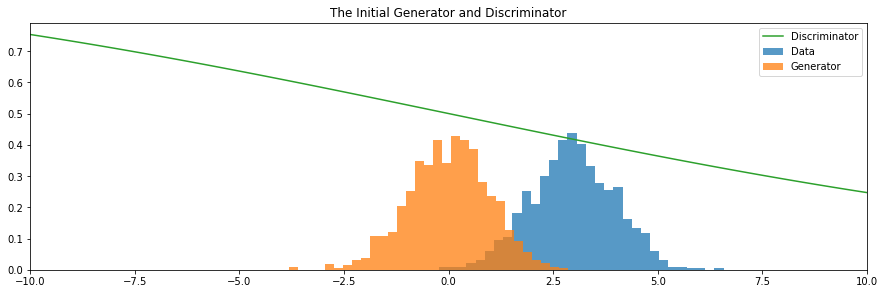

In [0]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.hist(data, bins = int(np.sqrt(N)), label='Data', alpha = .75, lw = 3, density = True)
plt.hist(x_g, bins = int(np.sqrt(N)), label = 'Generator', alpha = .75, lw = 3, density = True)
plt.plot(np.linspace(-10,10, 100), d_sig, label = 'Discriminator')
plt.title('The Initial Generator and Discriminator')
plt.legend()
plt.xlim([-10,10])
plt.show()

In [0]:
# Create Torch Dataloader
batch_size = N
real_ds = torch.utils.data.TensorDataset(torch.from_numpy(data.copy()))
real_ds_loader = torch.utils.data.DataLoader(real_ds, batch_size=batch_size,
                                             shuffle = True)

In [0]:
# Initialize BCELoss function
criterion = nn.BCELoss()

opt_G = optim.SGD(netG.parameters(), lr = 0.35)
opt_D = optim.SGD(netD.parameters(), lr = 0.35)

In [0]:
num_epochs = 160

real_label = 1
fake_label = 0

plot_info = [(x_g, d_sig, 0, None)]



for epoch in range(num_epochs):
  for step, batch in enumerate(real_ds_loader):
    netD.zero_grad()
    ### Train D

    # Train on a batch of real data 
    x = batch[0]
    b_size = x.size(0)
    label = torch.full((b_size,), real_label)
    output = netD(x).view(-1)
    loss_real = criterion(output, label)
    loss_real.backward()


    # Train with all-fake batch
    noise = torch.randn(b_size)
    fake = netG(noise)
    label.fill_(fake_label)
    output = netD(fake.detach()).view(-1)
    loss_fake = criterion(output, label)
    # Calculate the gradients for this batch
    loss_fake.backward()
    loss_total = loss_real + loss_fake
    # Update D
    opt_D.step()

    with torch.no_grad():
      d_sig = netD(torch.linspace(-10,10)).detach().numpy()
    plot_info.append((x_g, d_sig, epoch+1, 'D'))
    
    ### Train G
    netG.zero_grad()
    label.fill_(real_label)  
    output = netD(fake).view(-1)
    loss = criterion(output, label)
    loss.backward()
    opt_G.step()

    with torch.no_grad():
      x_g = netG(torch.from_numpy(noise_fixed)).detach().numpy()
      

    plot_info.append((x_g, d_sig, epoch+1, 'G'))

/pytorch/aten/src/ATen/native/TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.


In [0]:
fig, ax = plt.subplots(figsize=(15,5))
hist_d= ax.hist([])
hist_g = ax.hist([])
line_d = ax.plot([])
line_thresh = ax.plot([])
ax.set_ylim([0,1.05])
ax.set_xlim([-10,10])

plt.close()

def update_plot(i):
  x_g, d_sig, epoch, step  = plot_info[i]
  ax.cla()
  hist_d= ax.hist(data, bins = int(np.sqrt(N)), label='Data', alpha = .75, lw = 3, density = True)
  hist_g = ax.hist(x_g, bins = int(np.sqrt(N)), label = 'Generator', alpha = .75, lw = 3, density = True)
  line_d = ax.plot(np.linspace(-10,10, 100), d_sig, label = 'Discriminator')
  if step == None:
    ax.set_title('Initial Generator and Discriminator')
  else:
    ax.set_title('The Generator and Discriminator at Epoch {} After the {} step'.format(epoch, step))
  ax.set_xlim([-10,10])
  ax.set_ylim([0,1.05])
  ax.legend(loc='upper left')
  ax.grid('on', linestyle=':')
  ax.set_yticks(np.linspace(0,1,5))
  return(hist_d, hist_g, line_d)

In [0]:
%%capture --no-display
number_of_frames = len(plot_info)
anim = animation.FuncAnimation(fig, update_plot, number_of_frames)
HTML("<center>{}</center>".format(anim.to_html5_video()))

# Reference:
1. [PyTorch DCGAN tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)